<a href="https://colab.research.google.com/github/frantu08/Deep_Neural_Networks_Unit_2021/blob/main/2363E_DNN_Assign_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

### Ferenc Huszar, Nic Lane and Neil Lawrence

### 9th February 2021

Welcome to the first assignment for the Deep Neural Networks module. This assignment will test the principles that we have looked at in the first five lectures. 




## Double Descent

This assignment has six questions for a total of 100 marks.

### Background

In this assignment we are going to start by exploring a recent paper on the 'double descent phenomenon'. 

In [Belkin et al](https://www.pnas.org/content/116/32/15849.short) the authors explore double descent, firstly using *random Fourier features* as a basis function. We quote from their paper below.

> We first consider a popular class of nonlinear parametric models  called random Fourier features (RFF) (13), which can be viewed as a class of 2-layer neural networks with fixed weights in the first layer. The RFF model family $\mathcal{H}_N$ with $N$ (complex-valued) parameters consists of functions
$h : \mathbb{R}^d \rightarrow \mathbb{C}$ of the form
$$
h(x) =\sum_{k=1}^N a_k \phi(x ; v_k ) \quad \text{where} \quad \phi(x ; v_k) := e^{\sqrt{-1}\langle v_k, x\rangle},
$$ 
and the vectors $v_1, \dots , v_N$ are sampled independently from the
standard normal distribution in $\mathbb{R}^d$.

From Belkin et al. pg 2 of paper, section titled **Random Fourier Features**. For more on random Fourier features see [Rahimi and Recht](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf).


**Note** that the notation that Belkin et al use, $\langle v_k, x \rangle$ is just the notation for an inner product between the vector $v_k$ and the vector $x$. We'll use the notation $v_k^\top x$ to denote this below.

Following the papers description, our first task is to create a function for computing the basis. The paper proposes using a basis which is
$$
\exp(i z) = \cos(z) + i \sin(z)
$$
to form the *random Fourier features*. This leads to complex valued weights, $\{a_k\}_{i=1}^N$. So rather than doing that, we set our design matrix up in the following way:
$$
\boldsymbol{\Phi} = \begin{bmatrix} \cos(v_1^\top x_1) & \sin(v_1^\top x_1) & cos(v_2^\top x_1) & \sin(v_2^\top x_1) & \cdots & \cos(v_N^\top x_1) & \sin(v_N^\top x_1) \\
\cos(v_1^\top x_2) & \sin(v_1^\top x_2) & cos(v_2^\top x_2) & \sin(v_2^\top x_2) & \cdots & \cos(v_N^\top x_2) & \sin(v_N^\top x_2) \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
\cos(v_1^\top x_n) & \sin(v_1^\top x_n) & cos(v_2^\top x_n) & \sin(v_2^\top x_n) & \cdots & \cos(v_N^\top x_n) & \sin(v_N^\top x_n)\end{bmatrix}
$$
Giving us a matrix $\boldsymbol{\Phi} \in \mathbb{R}^{n \times 2N}$ where we are following Belkin et al's notation with $n$ number of data points and $N$ number of random Fourier features. Note that because each feature (in our representation) contains a sine and a cosine, the total number of basis functions is $2N$. 

The frequencies of the features, as Belkin et al explain, should be sampled from a normal density. In our notation below we collect these features in a matrix `V`, represented here as a two dimensional `numpy` array.  

If the data is stored in a That leads to the following code for implementing the random Fourier features.

In [ ]:
import numpy as np

In [ ]:
def random_fourier_basis(X, V):
  arg = X@V
  Phi = np.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = np.cos(arg) 
  Phi[:, 1::2] = np.sin(arg)
  return Phi

Given our design matrix, $\boldsymbol{\Phi}$ we can compute the output of the functions, which Belkin et al denote $h(x)$ for each of the points using matrix multiplication. 
$$
\mathbf{h} = \boldsymbol{\Phi} \mathbf{a}
$$
where $\mathbf{a} \in \mathbb{R}^N$ is a vector containing the elements $a_k$.


In [ ]:
def predict(X_test, a, V): # returns h(x) which is the output of the functions, hence the ys
  Phi_test = random_fourier_basis(X_test, V)
  return Phi_test@a

> Our learning procedure using $\mathcal{H}_N$ is as follows. Given data $(x_1, y_1), \dots , (x_n , y_n )$ from $\mathbb{R}^{d} \times \mathbb{R}$, we find the predictor $h_{n,N} \in \mathcal{H}_N$ via ERM with squared loss. That is, we minimize the empirical risk objective $\frac{1}{n} \sum_{i=1}^n (h(x_i) − y_i)^2$
over all functions $h \in \mathcal{H}_N$. When the minimizer is not unique (as is always the case when $N > n$), we choose the minimizer whose coefficients $(a_1, \dots , a_N )$ have the minimum $\ell_2$ norm. This choice of norm is intended as an approximation to the RKHS norm $\|h\|_{\mathcal{H}_\infty}$, which is generally difficult to compute for arbitrary functions in $\mathcal{H}_N$ . For problems with multiple outputs (e.g., multiclass classification), we use functions with vector-valued outputs and the sum of the squared losses for each output.

We already reviewed empirical risk minimization in the second lecture of week one. Here, Belkin et al are using the *squared loss* even for a classification task. This is probably not something you'd do in practice, but for our analysis below it will serve as it makes gradients easier to compute, and the optimum easy to solve analytically. 

We can implement the average squared error they described as follows. 

In [ ]:
def error(X, y, a, V):
  y_pred = predict(X, a, V)
  return np.mean((y_pred - y)**2)

And now we can implement the fixed point update equation we reviewed in [Lecture 2 of Week 1](https://mlatcl.github.io/deepnn/lectures/01-02-generalisation-and-neural-networks.html) for fitting the model.

In [ ]:
def fit(X_train, y_train, N, lambd=0.01):
  d = X_train.shape[1]
  V = np.random.normal(0.0, 1, size=(d, N))
  Phi_train = random_fourier_basis(X_train, V)
  if Phi_train.shape[1]>X_train.shape[0]:
    # N > n, use L2 regularizer
    a = np.linalg.solve(Phi_train.T@Phi_train + lambd*np.eye(N*2), Phi_train.T@y_train) #  .T = transpose
  else:
    a = np.linalg.solve(Phi_train.T@Phi_train, Phi_train.T@y_train)
  return a, V

Here we have included `lambd` to represent a regularisation parameter, so that we can minimize the $\ell_2$ norm as Belkin et al suggest when the number of parameters in the model (which is $2N$ for this random Fourier basis) is greater than the number of data, $n$. This is called [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization).

### Loading a Data Set

For their paper, Belkin et al use the MNIST digits data set. To make things run a little quicker for us, we'll use a digits data set from scikit learn. 

In [ ]:
import sklearn
from sklearn import datasets

digits = datasets.load_digits()

The original data has 10 digits. We'll modify the task form classifyign individual digits to separating curvy digits from those with angles. Our task will be to separate `0`, `3`, `6`, `8`, `9` from `1`, `2`, `4`, `5`, `7`. This leads to an approximate balance between positive and negative examples.

In [ ]:
X = digits['data']
y = ((digits['target'] == 0)
     | (digits['target'] == 3)
     | (digits['target'] == 6)
     | (digits['target'] == 8)
     | (digits['target'] == 9))

We will normalise the input data. Normalization is often a key part of getting machine learning algorithms working well. In many cases, you would normalize the columns of your data independently. But here, because it's an image, my instinct is to apply a single scaling. Because the pixels live naturally on the same scale originally. 

In [ ]:
import numpy as np
X /= X.std()
X /= np.sqrt(64) 

I've subsequently also scaled by the square root of the dimensionality. This ensures that on average, the length of the vector $x$ is 1/64, or in other words, $1/d$ where $d$ is the dimensionality of the input image (which is $8\times 8$).

Similarly, it's quite common to use labels of $-1$ or $1$ for targets when using a squared error. This works well because it's symmetric about zero. But an encoding of $0$ vs $1$ would also likely work. 

In [ ]:
y = y*2 - 1

We can use scikit learn's built in facility for forming a training and test set from the model. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=False)

And now we can use our code to fit our model. 

In [ ]:
a, V = fit(X_train, y_train, 200)

And check the error. 

In [ ]:
e = error(X_test, y_test, a, V)
print('Error: {}'.format(e))

Error: 0.3261333498216198


### Question 1

Fit models using different values for $N$ between 1 and 2000. 

Produce a plot that has an $x$-axis given by the number of parameters in the model (remember that's $2N$) divided by the number of *training* data. On the $y$-axis plot the loss computed on the *test* data. This serves as an estimate of the true risk.

Choose appropriate intervals for plotting so that the full form of the curve is seen. Beware that the fit will be slow as $N\rightarrow 2000$. 

You can use `matplotlib` or your preferred plotting library to create the plot.

Describe what you see in the plot with reference to both *classical* generalisation theory and the generalisation performance of modern neural network models.

*15 marks*

#### Answer 1 code
Below I try and interval of 10.

In [ ]:
## Place your code for your answer to question 1 in this box. 
interval = 10

list_N_values = np.arange(1,2000, interval)
x_axis = 2*list_N_values/len(X_train) # x-axis given by the number of parameters in the model (remember that's 2N) divided by the number of training data
y_train_axis = []
y_test_axis = []
# print(x_axis)

for N1 in list_N_values:
   a1, V1 = fit(X_train, y_train, N1)
   e1 = error(X_test, y_test, a1, V1)
   e2 = error(X_train, y_train, a1, V1)
   y_test_axis.append(e1) # y-axis plot the loss computed on the test data
   y_train_axis.append(e2)

x_axis = x_axis.tolist()

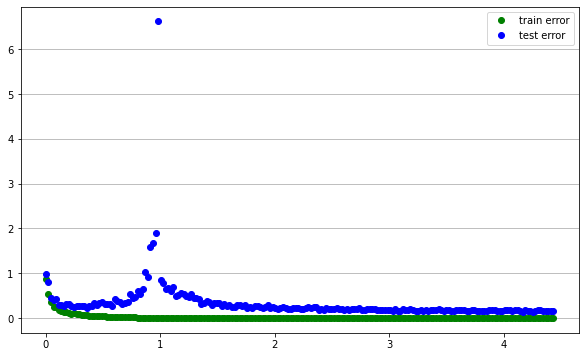

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_train_axis,'go', label='train error')
plt.plot(x_axis, y_test_axis, 'bo', label='test error')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

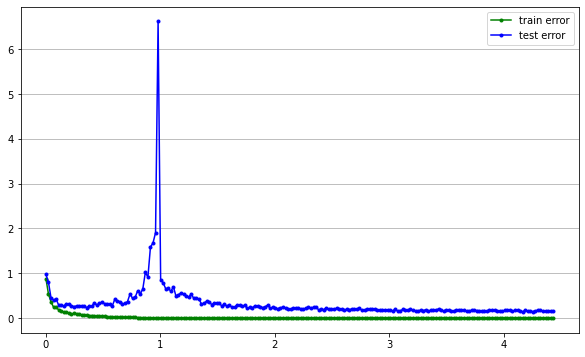

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_train_axis,'.g-', label='train error')
plt.plot(x_axis, y_test_axis, '.b-', label='test error')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

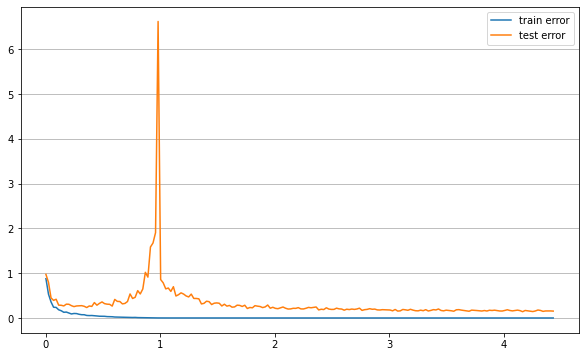

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_train_axis, label='train error')
plt.plot(x_axis, y_test_axis, label='test error')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

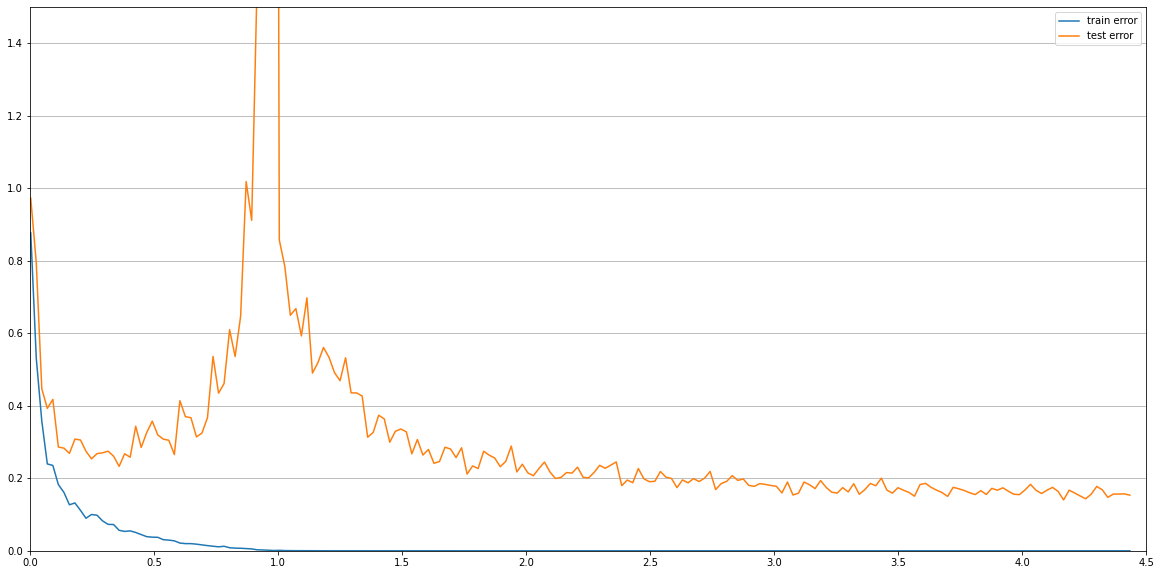

In [ ]:
plt.figure(figsize=(20, 10))
plt.axis([0, 4.5, 0, 1.5])
plt.plot(x_axis, y_train_axis, label='train error')
plt.plot(x_axis, y_test_axis, label='test error')
axes = plt.gca()
axes.yaxis.grid()
plt.legend() 

#### Answer 1 code:
Now I try all values for N from 2 to 1999

In [ ]:
list_N_values_2 = np.arange(2,2000)
x_axis_2 = 2*list_N_values_2/len(X_train)  # x-axis given by the number of parameters in the model (remember that's 2N) divided by the number of training data
y_test_axis_2 = []
y_train_axis_2 = []

for N2 in list_N_values_2:
   a1, V1 = fit(X_train, y_train, N2)
   e1 = error(X_test, y_test, a1, V1)
   e2 = error(X_train, y_train, a1, V1)
   y_test_axis_2.append(e1) # y-axis plot the loss computed on the test data
   y_train_axis_2.append(e2)

x_axis_2 = x_axis_2.tolist()

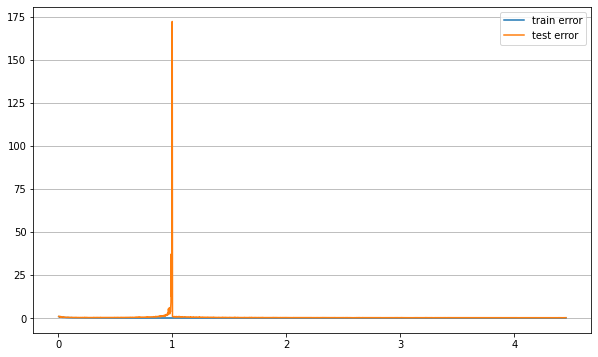

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_axis_2, y_train_axis_2, label='train error')
plt.plot(x_axis_2, y_test_axis_2, label='test error')
axes = plt.gca()
axes.yaxis.grid()
plt.legend()

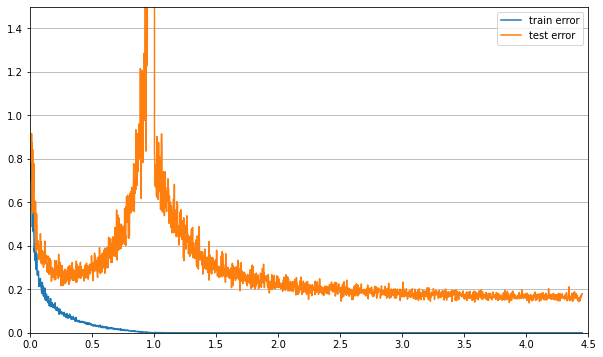

In [ ]:
plt.figure(figsize=(10, 6))
plt.axis([0, 4.5, 0, 1.5])
plt.plot(x_axis_2, y_train_axis_2, label='train error')
plt.plot(x_axis_2, y_test_axis_2, label='test error')
axes = plt.gca()
axes.yaxis.grid()
plt.legend()
plt.show()

#### Answer 1 text

Place your description of the plot in this box.



*Describe what you see in the plot with reference to both *classical* generalisation theory and the generalisation performance of modern neural network models*



In the plots I indentify a manifestation of double descent, as the "risk" (fow which here we only used an estimate) comes back to earth after a short trip to the moon with "Daddy bear" (as per notes) and adventures into the dark forest towards Grandma's safe house and the bad wolves at the same time.

The traditional view on generalisation is that we start with high bias (underfiiting, given that the capacity is small) and as we're increasing the capacity of $\mathcal{H}_N$, (here by just increasing N), we hit the ideal spot where training error is normally not zero yet, but the test risk is minimal (good bias-variance tradeoff). We can see that on the first part of the graph, the optimal sweet spot before $0.5$ on the $x$ axis (more accurately around $2.5 - 3$ on the last plot).

However, as we furhter increase the capacity, the training risk goes towards zero (as we overfit), but the test risk increases and can reach absurd rates as the variance increases. The peak is called the interpolation threshold. We can see that around the value $1$ on the $x$ axis.

However, in Neural Networks we observe the phenomenon of double descent, which is present in our graph as well. Double descent comes from the fact that the training error descends twice. As we absurdly overparameterise the model, the train risk is already at 0, but the test risk goes down. The only catch is that if we go too far, we risk the model overfitting, even "memorising" data. 

In the graph, the test risk goes down after $1$, the train remains at zero while the test risk goes down.


## Gradient descent in pytorch

 Having seen the model above written in `numpy` we are now going to explore the same model in `pytorch`. First we rewrite our basis functions.

In [ ]:
import torch

In [ ]:
def random_fourier_basis(X, V):
  arg = X@V
  Phi = torch.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = torch.cos(arg) 
  Phi[:, 1::2] = torch.sin(arg)
  return Phi

In [ ]:
def predict(X_test, a, V):
  Phi_test = random_fourier_basis(X_test, V)
  return Phi_test@a

In [ ]:
def error(X, y, a, V):
  y_pred = predict(X, a, V)
  return torch.mean((y_pred - y)**2)


In [ ]:
# For completeness we also include the function for 'direct fit' in pytorch. You 
# don't need it for the answers below but you can use it to check convergence
# if you like.

def fit(X_train, y_train, N, lambd=0.01):
  d = X_train.shape[1]
  V = torch.normal(0.0, 1, size=(d, N))
  Phi_train = random_fourier_basis(X_train, V)
  if Phi_train.shape[1]>X_train.shape[0]:
    # N > n, use L2 regularizer
    a, LU = torch.solve(Phi_train.T@y_train, Phi_train.T@Phi_train + lambd*eye(N*2))
  else:
    a, LU = torch.solve(Phi_train.T@y_train, Phi_train.T@Phi_train)
  return a, V

Because we will fit these models with gradient descent now, we have to randomly initialize the parameters.

 -- I gave N a value of 200 for no particular reason

In [ ]:
N = 200

In [ ]:
a = torch.normal(0, 0.001, size=(2*N, 1))
V = torch.normal(0.0, 1, size=(X.shape[1], N))

We also have to tell `torch` that `a` is a variable that we would like to later calculate gradients with respect to, using the `.requires_grad` attribute. The result of this is that wherever we use the variable `a` in subsequent Maths operations, a computational graph with all those operations is going to be built in the background. This computational graph is what allows the `autograd` module of `torch` to later calculate gradients using reverse-mode automatic differentiation, a.k.a. backpropagation.

As in this example we assume `V` to be fixed to randomly selected values, and not learned, so we don't need to do the same for that variable.

In [ ]:
a.requires_grad=True

*We* need to convert our training and test data from `numpy` arrays into `pytorch` tensors. Note that by default pytoch works with single precision, so we also convert these data arrays (which are `double` in `numpy`) to `float`.

In [ ]:
Xt_train = torch.from_numpy(X_train).float()
Xt_test = torch.from_numpy(X_test).float()
yt_train = torch.from_numpy(y_train[:, np.newaxis]).float()
yt_test = torch.from_numpy(y_test[:, np.newaxis]).float()

The magic of automatic differentiation allows us to compute the gradients in `pytorch` by requesting `.backward()`. This function can be called on any `pytorch` tensor that has a computational graph attached. Backpropagation will walk bacjwards on this computational graph and save the relevant gradients in the `.grad` attribute of each `Tensor` whose `requires_grad` attribute is set to `True.`

In [ ]:
error(Xt_train, yt_train, a, V).backward()

And now we can simply look at the gradient from pytorch.

In [ ]:
 a.grad

tensor([[ 0.0380],
        [ 0.1268],
        [ 0.0821],
        [-0.1860],
        [ 0.0169],
        [-0.2508],
        [-0.0326],
        [-0.0708],
        [ 0.0808],
        [ 0.2211],
        [ 0.3223],
        [ 0.0857],
        [-0.0763],
        [-0.0669],
        [-0.3970],
        [ 0.0502],
        [-0.2691],
        [ 0.1474],
        [ 0.2714],
        [ 0.2644],
        [ 0.0343],
        [-0.0669],
        [-0.0574],
        [ 0.0176],
        [-0.0144],
        [-0.0732],
        [-0.3892],
        [ 0.1513],
        [ 0.1455],
        [ 0.1417],
        [-0.1277],
        [-0.0412],
        [-0.2381],
        [ 0.3168],
        [ 0.0068],
        [-0.1263],
        [-0.2175],
        [-0.1070],
        [-0.4679],
        [-0.7986],
        [-0.2004],
        [ 0.1360],
        [ 0.0392],
        [ 0.0992],
        [-0.0959],
        [ 0.0624],
        [ 0.0218],
        [ 0.2930],
        [-0.2492],
        [ 0.4689],
        [-0.1267],
        [-0.0469],
        [-0.

In [ ]:
len(a.grad)

400

### Question 2

Analytically derive the gradient for the objective function with respect to parameters $\mathbf{a}$. Give your answer in the box below.

Then implement the answer in code and compare the gradient to the values given by `autograd` in `pytorch` with a scatter plot.

*10 marks*

#### Answer 2 

*Please add your answer by completing the equation below.*

(for some reason this only renders completely correctly on colab)

The gradient of the loss with respect to $\mathbf{a}$ is:
$$
\frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) = ?
$$

$$
\frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})
$$

Let's use the following properties from the notes:

$$\frac{\text{d}}{\text{d}\mathbf{a}}\mathbf{z}^\top \mathbf{a} = \mathbf{z} \\(1)$$ 

$$\frac{\text{d}}{\text{d} \mathbf{a}} \mathbf{a}^ \top \mathbf{C} \mathbf{a}=  \mathbf{C} \mathbf{a} + \mathbf{C}^\top\mathbf{a} $$ 

And when $\mathbf{C}$ is symmetric ($\mathbf{C} = \mathbf{C}^\top$) and the derivative simplifies to $$
\frac{\text{d}}{\text{d}\mathbf{a}} \mathbf{a}^\top\mathbf{C}\mathbf{a}=
2\mathbf{C}\mathbf{a} \\(2)
$$

In both, $\mathbf{a}$ is a column vector.


And now, as per the notes, expand the general expression:

$$
(\mathbf{a} - \mathbf{b})^\top
(\mathbf{c} - \mathbf{d}) = \mathbf{a}^\top \mathbf{c} - \mathbf{a}^\top
\mathbf{d} - \mathbf{b}^\top \mathbf{c} + \mathbf{b}^\top \mathbf{d}
\\
$$ and substitute for $\mathbf{a} = \mathbf{c} = \mathbf{ y}$ and
$\mathbf{b}=\mathbf{d} = \boldsymbol{ \Phi}\mathbf{ a}$, obtaining 


$$(\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) =
\mathbf{ y}^\top\mathbf{ y}- 2\mathbf{ y}^\top\boldsymbol{ \Phi}\mathbf{ a}+
\mathbf{ a}^\top\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ a}
\\(3)$$ 
Note: we used
$\mathbf{ y}^\top\boldsymbol{ \Phi}\mathbf{ a}=\mathbf{ a}^\top\boldsymbol{ \Phi}^\top\mathbf{ y}$ (as they're symmetric and both are a scalar).

Since $\mathbf{n}$ is not a function of $\mathbf{a}$:
$$
\frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) = \frac{1}{n} \frac{\text{d}}{\text{d} \mathbf{a}} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) \\(4)$$

Using (3) and the independence between $\mathbf{y}$ and $\mathbf{a}$ we get:

$$ \frac{\text{d}}{\text{d} \mathbf{a}} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) = 
\frac{\text{d}}{\text{d} \mathbf{a}}(- 2\mathbf{ y}^\top\boldsymbol{ \Phi}\mathbf{ a}+
\mathbf{ a}^\top\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ a})  = 
 - \frac{\text{d}}{\text{d} \mathbf{a}}2\mathbf{ y}^\top\boldsymbol{ \Phi}\mathbf{ a} + \frac{\text{d}}{\text{d} \mathbf{a}}\mathbf{ a}^\top\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ a} \\(5)$$

Using (1) on the first term of the result (5) we get:
$$\frac{\text{d}}{\text{d} \mathbf{a}}2\mathbf{ y}^\top\boldsymbol{ \Phi}\mathbf{ a} = 2\mathbf{ \Phi}^\top\boldsymbol{ y} \\(6)$$

Now given that $\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}$ is symmetric, using (2) on the second term of the result (5) we get:

$$\frac{\text{d}}{\text{d} \mathbf{a}}\mathbf{ a}^\top\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ a} = 2\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ a} \\(7)$$


Substituting the (5), (6), (7) back in (4) we get:
$$
\frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) = \frac{2}{n}(- \boldsymbol{ \Phi}^\top \mathbf{ y}+
\boldsymbol{ \Phi}^\top\boldsymbol{ \Phi}\mathbf{ a})
$$










In [ ]:
## Place your code for your answer to question 2 in this box
## Answer 2 Part 2: Implement the answer in code and compare the gradient to the values given by `autograd` in `pytorch` with a scatter plot.

def a_grad(a, N, Xt_train, yt_train):
  n = len(Xt_train)
  d = Xt_train.shape[1]
  Phi_train = random_fourier_basis(Xt_train, V)
  grad = Phi_train.T@Phi_train@a - Phi_train.T@yt_train 
  return 2*grad/n

In [ ]:
x_axis_t = a_grad(a, N, Xt_train, yt_train)
y_axis_t = a.grad
x_axis = x_axis_t.tolist()
y_axis = y_axis_t.tolist()
x_axis = list(np.concatenate(x_axis).flat)
y_axis = list(np.concatenate(y_axis).flat)

#### Answer 2: the scatter plot

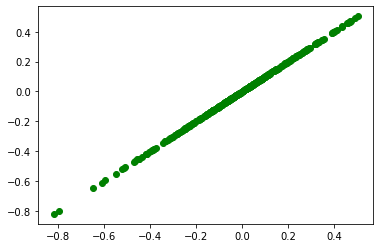

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x_axis,y_axis, 'go')
plt.show()

#### Answer 2 Part 2:

As we can see above, we get perfect correlation between a.grad and the manually implemented formula for gradients.

### A simple SGD training loop

Optimisaton of neural networks is typically done by some variant of gradient descent. `pytorch` provides some convenient omptimizaton routines, like `torch.optim.SGD` that we can use to fit the stochastic gradient descent algorithm. 

We include an example of a simple stochastic gradient descent training loop below.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def sgd_fit(
    X_train, y_train,
    N, a_std = 0.001,
    lr=0.001, epochs=100, batchsize=90):
  ''' Fits a generalised linear model with N random fourier features
  to data using stochastic gradient descent.

  Parameters
  ----------
  X_train, y_train : torch.Tensor
    Training input and output tensors
  N : int
    Number of random Fourier features to use
  a_std : float
    Standard deviation of parameters a at initialization
  lr : float
    Learning rate
  epochs : int
    Number of training epochs
  batchsize : int
    Number of datapoints in each minibatch

  Returns
  -------
  a, V
    torch.Tensors contatining parameters of the trained model
  '''
  dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
  )
  a = torch.normal(0, a_std, size=(2*N, 1))
  a.requires_grad=True
  V = torch.normal(0.0, 1, size=(X.shape[1], N))
  optimizer = torch.optim.SGD([a], lr=lr)
  for t in range(epochs):
    for X_minibatch, y_minibatch in dataloader:
	    optimizer.zero_grad()
	    error(X_minibatch, y_minibatch, a, V).backward()
	    optimizer.step()
  return a, V

Note: In practice, one would not write a training loop from scratch like this. There are well-tested libraries with extensive functionality like `ignite` in pytorch and `keras` in TensorFlow. We included this simple code so as to illustrate what is going on in a SGD training loop.

### Question 3

Now we have used `pytorch` to compute the gradients, we'll optimize with stochastic gradient descent. 

Firstly, you'll look at the convergence of stochastic gradient descent for four different sizes of model, $N=5$, $N=100$, $N=400$ and $N=1000$.

Modify the `sgd_fit` code to monitor convergence of both the test error and the training error as training progresses.
*italicised text*
Produce plots of the changing training and test error as the iterations procede for each model size $N$ above.

For each model size ($N$) vary the the learning rate, number of iterations, batchsize, to improve the rate of convergence.

You may want to use `torch.manual_seed` to set the random seed. Try different random seeds. What do you find?

*15 marks*



In [ ]:
## You can modify the function below to create your answers
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

def sgd_fit_plot(
    X_train, y_train, X_test, y_test,
    N, a_std = 0.001,
    lr=0.001, epochs=100, batchsize=30, manual_seed = None):
  dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
  )
  if (manual_seed == None):
    a = torch.normal(0, a_std, size=(2*N, 1))
  else:
    a = torch.normal(0, a_std, generator= torch.manual_seed(manual_seed), size=(2*N, 1))  
  a.requires_grad=True
  V = torch.normal(0.0, 1, size=(X.shape[1], N))
  optimizer = torch.optim.SGD([a], lr=lr)
  train_error = []
  test_error = []
  for t in range(epochs):
    for X_minibatch, y_minibatch in dataloader:
	    optimizer.zero_grad()
	    error(X_minibatch, y_minibatch, a, V).backward()
	    optimizer.step()
    train_error.append(error(X_train, y_train, a, V))
    test_error.append(error(X_test, y_test, a, V))
  l = len(train_error)  
  plt.plot(range(l), train_error, label='train error')
  plt.plot(range(l), test_error, label='test error')
  axes = plt.gca()
  axes.yaxis.grid()
  plt.legend()  
  # return a, V, train_error, test_error

#### 5

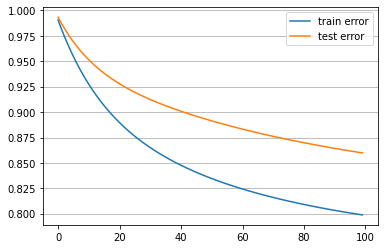

In [ ]:
## Place your code for your answer to question 3 for N=5 in this box.
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5)

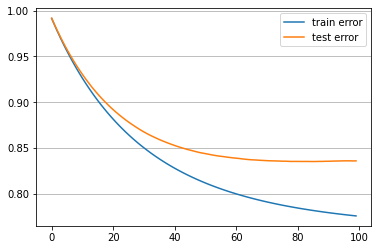

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, manual_seed = 1234) # ok with 100 epochs

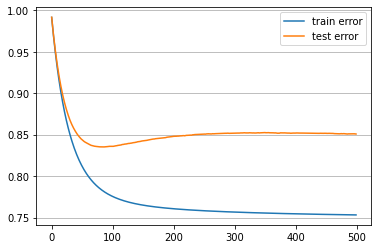

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, manual_seed = 1234, epochs = 500) # manual_seed 1234 is damaging with 500 epochs

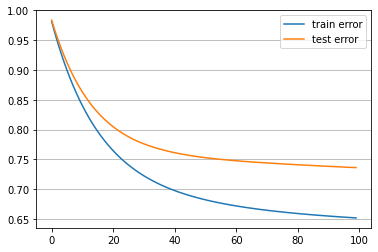

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, manual_seed = 765) # this seed helps!

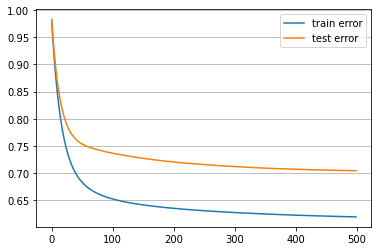

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, manual_seed = 765, epochs = 500) # it really does!

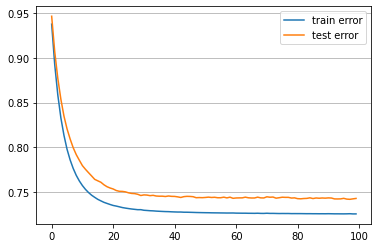

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.001, epochs=100, batchsize=5) # smaller learning rates and small batch sizes agree

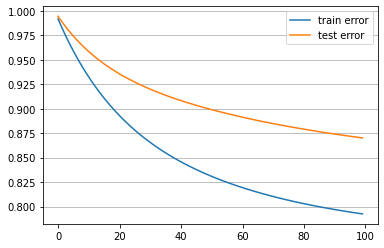

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.001, epochs=100, batchsize=30)

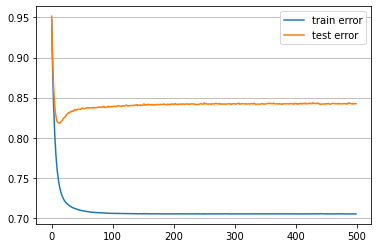

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.001, epochs=500, batchsize=5)

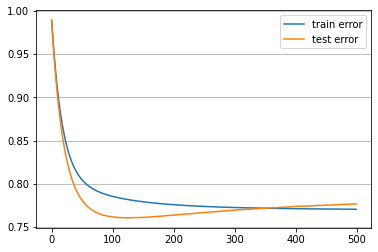

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.001, epochs=500, batchsize=30) 

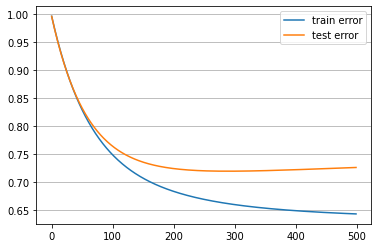

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.001, epochs=500, batchsize=90) # the error goes up after 300-400 batches

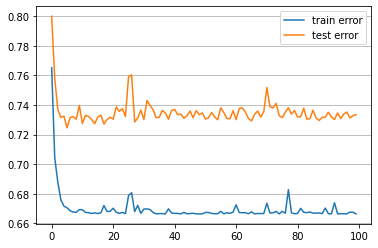

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.005, epochs=100, batchsize=5) # smaller batchsize don't give a smooth curve

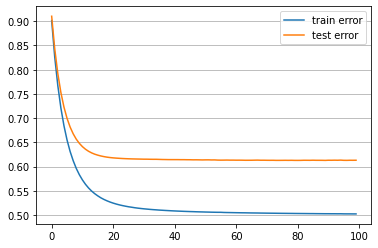

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.005, epochs=100, batchsize=30) # this is the best so far, maybe adding the good manual seed will help

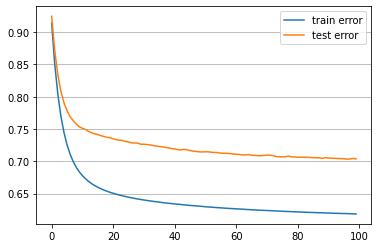

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, manual_seed= 765, lr=0.005, epochs=100, batchsize=30) # sadly, adding the manual seed 765 didn't help here

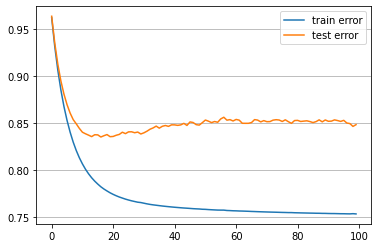

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, manual_seed= 1234, lr=0.005, epochs=100, batchsize=30) # adding the manual seed 1234 didn't help either

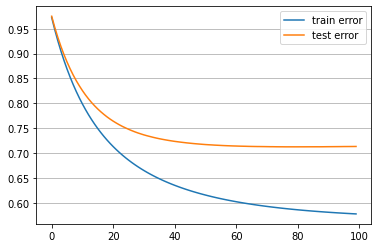

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.005, epochs=100, batchsize=90)

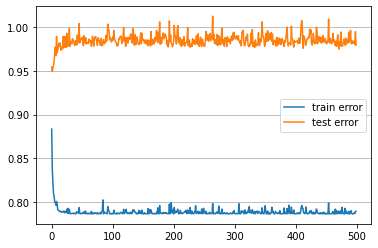

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.005, epochs=500, batchsize=5) # higher learning rates with small batch sizes don't agree

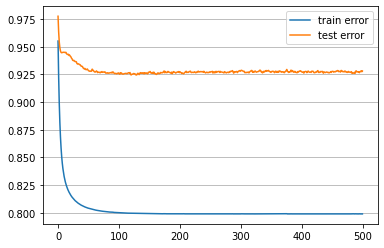

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.005, epochs=500, batchsize=30)

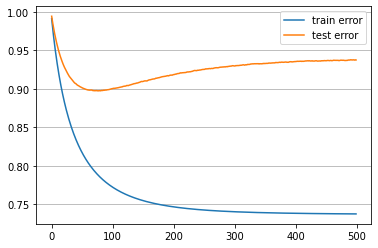

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.005, epochs=500, batchsize=90)

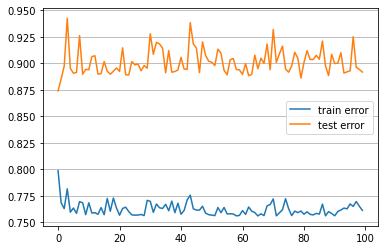

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.01, epochs=100, batchsize=5)

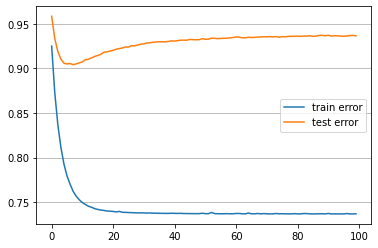

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.01, epochs=100, batchsize=30)

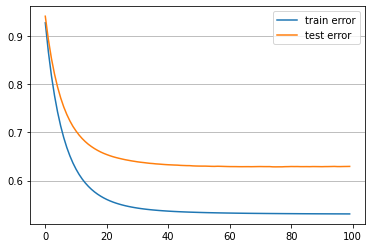

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.01, epochs=100, batchsize=90) # higher learning rates agree with larger batch sizes

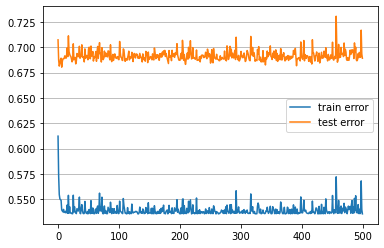

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.01, epochs=500, batchsize=5) # small batch sizes produce bumpy curves, but the error is still better than most

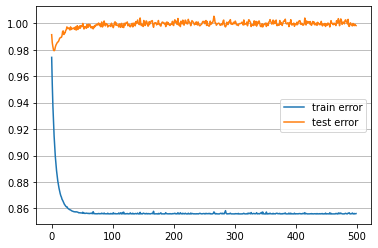

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.01, epochs=500, batchsize=30) # larger learning rates don't agree with small batch sizes

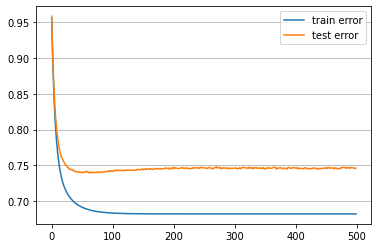

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.01, epochs=500, batchsize=90) 

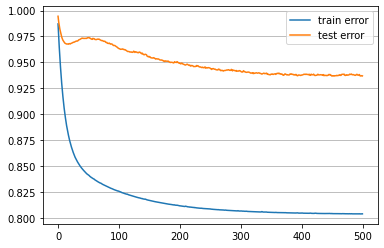

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 5, lr=0.01, epochs=500, batchsize=120)

#### Best result for N = 5:
lr = 0.005, epochs = 100, batch_size = 30

#### 100

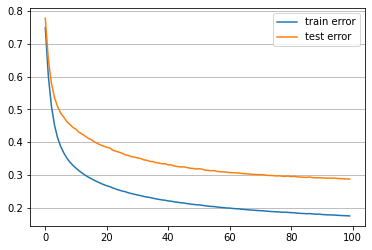

In [ ]:
## Place your code for your answer to question 3 for N=100 in this box.
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100) # already using N = 100 decreases the error dramatically, below 0.3

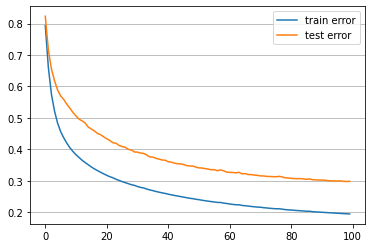

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, manual_seed = 1234) # this seed is good here, but does worse than no seed

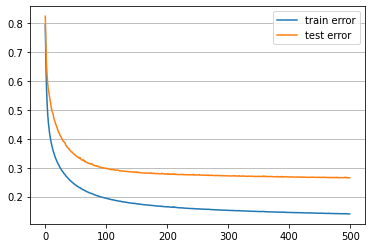

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, manual_seed = 1234, epochs = 500) # this seed is good here with more epochs

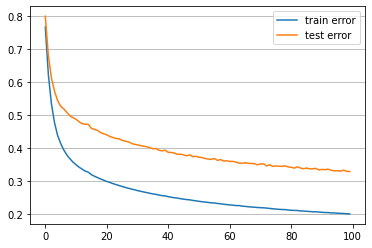

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, manual_seed = 765) # this one goes down, but still not better than no seed

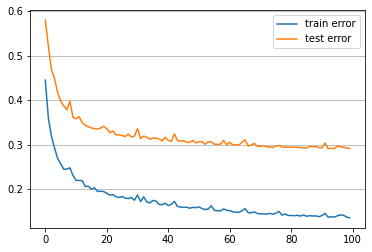

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.001, epochs=100, batchsize=5) # small lr and small batch size

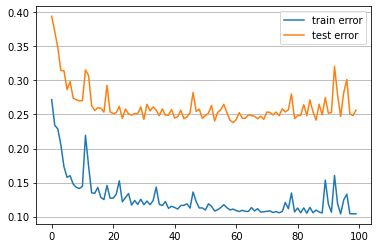

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.001, epochs=100, batchsize=1) # small lr and small and 1 batch size of 1, not really stable, but achieves good values

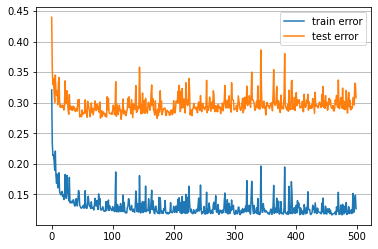

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.001, epochs=500, batchsize=1) # small lr and small and 1 batch size of 1, even more epochs, no improvement, error is eve going up a bit

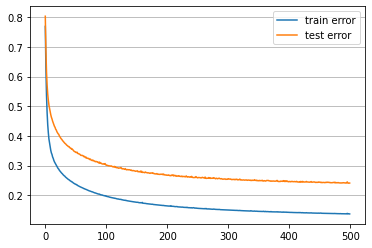

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.001, epochs=500, batchsize=30) # more epochs take the error even lower

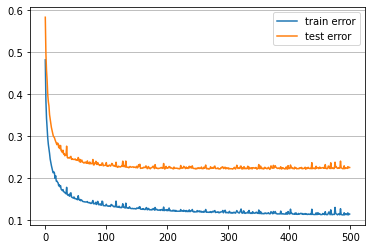

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.005, epochs=500, batchsize=30) # larger lr helps error converge faster

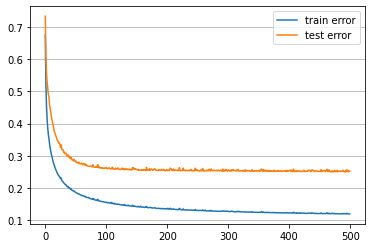

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.005, epochs=500, batchsize=90) # larger lr helps error converge faster, higher lr and larger batchsize agree

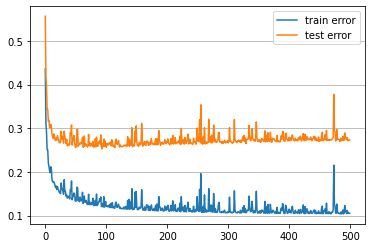

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.01, epochs=500, batchsize=30) # too many epochs

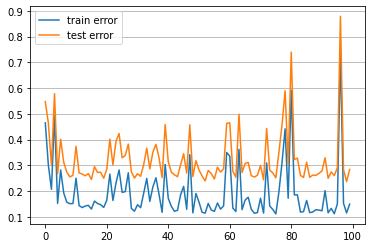

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.01, epochs=100, batchsize=5) # again, lr and batchsize must either be both small or both high

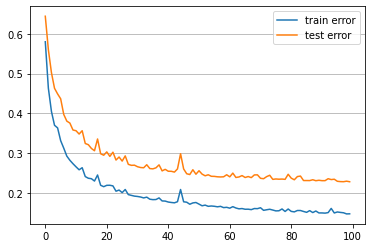

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.01, epochs=100, batchsize=90) # that's what I'm talking about

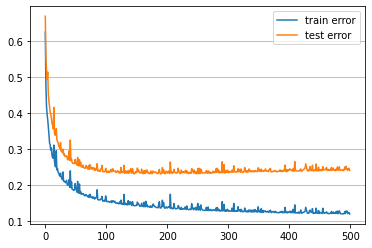

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 100, lr=0.01, epochs=500, batchsize=120) # too many epochs ruin stuff

#### For 100: best 
lr=0.005, epochs=500, batchsize=30 

#### 400

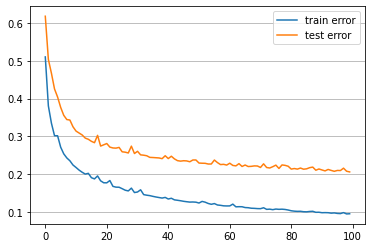

In [ ]:
## Place your code for your answer to question 3 for N=400 in this box.
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400) #  already having N=400 makes learning rate approach 0.2

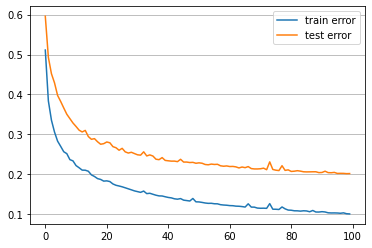

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, manual_seed = 1234) # helping a bit

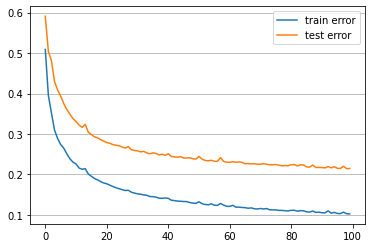

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, manual_seed = 765) # not really helping

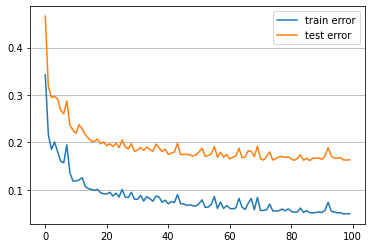

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.001, epochs=100, batchsize=5) # below 0.2, good

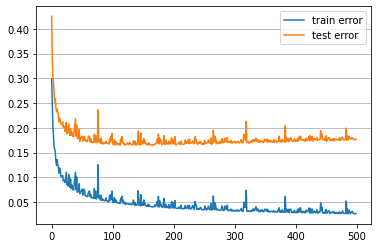

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.001, epochs=500, batchsize=5) # slightly going up after 300

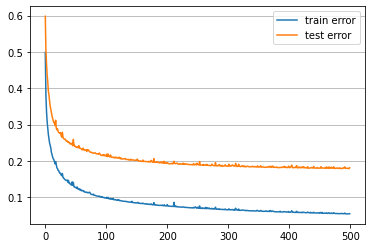

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.001, epochs=500, batchsize=30) # below 0.2, good

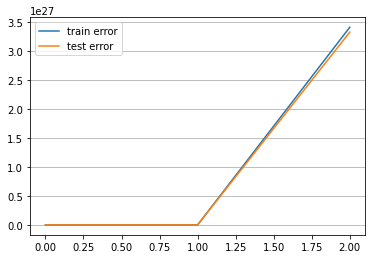

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.005, epochs=500, batchsize=30) # higher lr seems to be angry with my choice of invoking it 

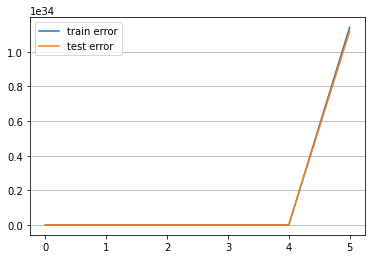

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.005, epochs=300, batchsize=50) # 

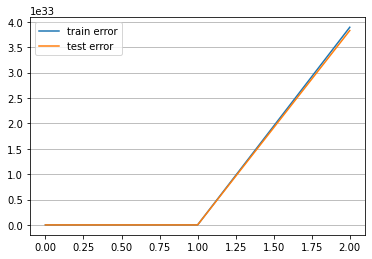

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.01, epochs=300, batchsize=90) # ok, I'll stick with lr = 0.001 

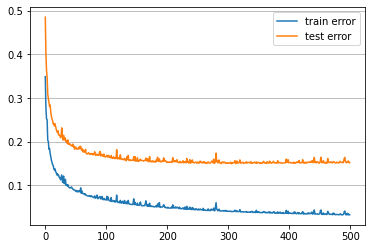

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.001, epochs=500, batchsize=10) # error seems to slightly start growing after close to 500 epochs, but error<0.2 is good

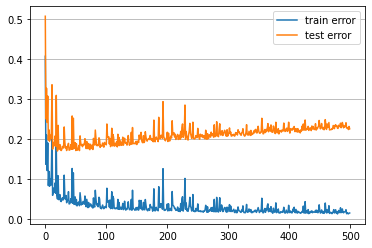

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.001, epochs=500, batchsize=1) # worth a try

#### For 400: 
lr=0.001, epochs=100, batchsize=5 did the best, must most did good (when lr and batchsize were proportional)

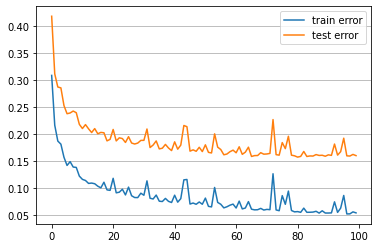

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 400, lr=0.001, epochs=100, batchsize=5) # below 0.2, good

#### 1000

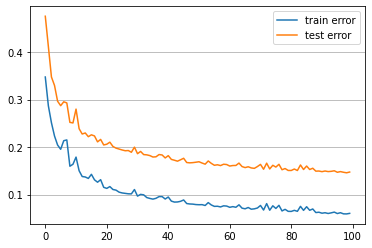

In [ ]:
## Place your code for your answer to question 3 for N=1000 in this box.
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000) # just using N = 1000 takes the error below 0.2

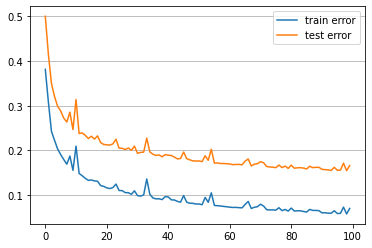

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, manual_seed = 1234) # manual seed not really making a dif

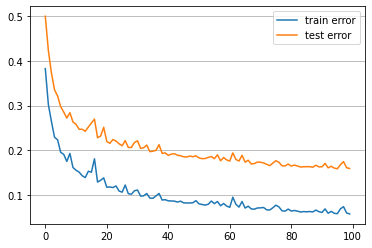

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, manual_seed = 765)  # manual seed not really making a dif

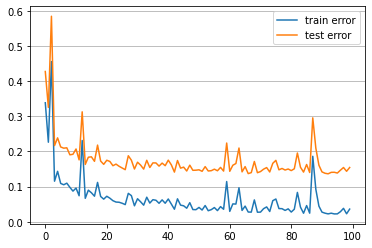

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, lr=0.001, epochs=100, batchsize=5) # good, but concerning spikes

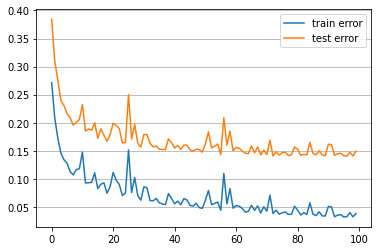

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, lr=0.001, epochs=100, batchsize=10) # better!

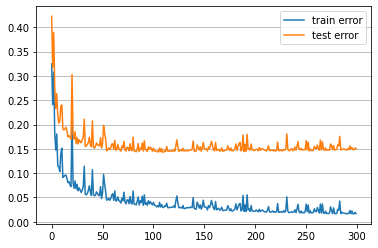

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, lr=0.001, epochs=300, batchsize=10) # quite an impressive result

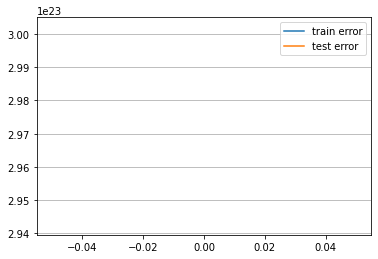

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, lr=0.005, epochs=300, batchsize=50) # ok, so stick to lr <= 0.001 for N>=400

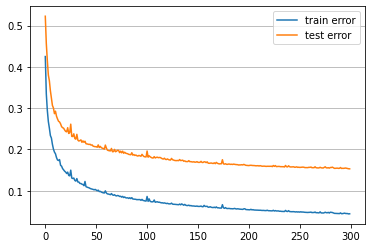

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, lr=0.0001, epochs=300, batchsize=5) # smaller lr makes for smoother conversion

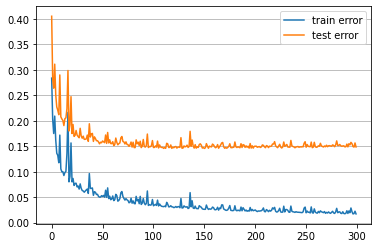

In [ ]:
sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, 1000, lr=0.0005, epochs=300, batchsize=5) # quite an impressive result

#### For N = 1000
lr=0.001, epochs=300, batchsize=10
and
lr=0.0005, epochs=300, batchsize=5 
do the best
with the 2nd one giving a smoother convergence

#### Answer 3 text

*Explain what you find see in the different plots in this text box.*

The main observations are that 

- Learning rate and batch size go hand in hand, which is also a general rule in practice: "bigger batch size bigger learning rate". We see here that lr = 0.001 goes well with batch sizes of 5, 10. The smaller the batchsize, the more bumpy the convergence. When increasing learning rate, the same thing happens (bumpy convergence), so it makes sense for the best choice to be somewhere in between.
- Just increasing $N$, giving a higher capacity to the model, and keeping the same initial hyperparameters is enough to decrease the error rate.
- Training over too many epochs may result in overtraining as the error starts to slightly increase after 300 epochs sometimes.
- When N is 400, a learning rate larger than 0.001 will sometimes give an absurd explosion. Such a learning rate doesn't seem to work on N = 1000 either. Adaptive learning rates could be used to solve this, but I haven't implemented that.
- As N increases, smaller learning rates will work better. If a constant learning rate is used, since over time as the epochs increase, the network will require more fine-grained weight updates (even smaller learning rates, so also an adaptive learning rate), then we shouldn't use too many epochs.



### Question 4

Use what you have learned about learning rates and number of training iterations to recreate the plot of test error against $2N/n$  but using stochastic gradient descent to plot the new model. 

Justify your choice of learning rate and model dimensionality.

Compare this plot with the direct fit you did in numpy above. How do they differ?

*20 marks*

In [ ]:
## Place your code for your answer to question 4 in this box.

def sgd_fit_1(
    X_train, y_train, X_test, y_test,
    N, a_std = 0.001,
    lr=0.001, epochs=100, batchsize=30, manual_seed = None):
  dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
  )
  if (manual_seed == None):
    a = torch.normal(0, a_std, size=(2*N, 1))
  else:
    a = torch.normal(0, a_std, generator= torch.manual_seed(manual_seed), size=(2*N, 1))  
  a.requires_grad=True
  V = torch.normal(0.0, 1, size=(X.shape[1], N))
  optimizer = torch.optim.SGD([a], lr=lr)
  train_error = []
  test_error = []
  for t in range(epochs):
    for X_minibatch, y_minibatch in dataloader:
	    optimizer.zero_grad()
	    error(X_minibatch, y_minibatch, a, V).backward()
	    optimizer.step()

  l = len(train_error)    
  train_error = error(X_train, y_train, a, V)
  test_error = error(X_test, y_test, a, V)
  return train_error, test_error

In [ ]:
## Place your code for your answer to question 1 in this box. 
interval = 100

list_N_values = np.arange(1,2000, interval)
x_axis = 2*list_N_values/len(Xt_train) # x-axis given by the number of parameters in the model (remember that's 2N) divided by the number of training data
y_train = []
y_test = []

for N1 in list_N_values:
   train_error, test_error = sgd_fit_1(Xt_train, yt_train, Xt_test, yt_test, N1)
   y_train.append(train_error) 
   y_test.append(test_error)

x_axis = x_axis.tolist()

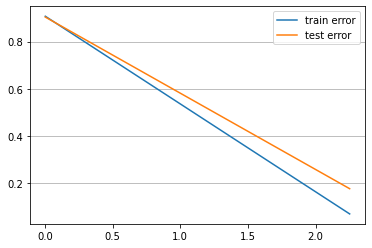

In [ ]:
  plt.plot(x_axis, y_train, label='train error')
  plt.plot(x_axis, y_test, label='test error')
  axes = plt.gca()
  axes.yaxis.grid()
  plt.legend() 

In [ ]:
## Place your code for your answer to question 1 in this box. 
interval = 50

list_N_values = np.arange(1,2000, interval)
x_axis = 2*list_N_values/len(Xt_train) # x-axis given by the number of parameters in the model (remember that's 2N) divided by the number of training data
y_train = []
y_test = []

for N1 in list_N_values:
   train_error, test_error = sgd_fit_1(Xt_train, yt_train, Xt_test, yt_test, N1, lr=0.001, epochs=300, batchsize=5)
   y_train.append(train_error) 
   y_test.append(test_error)

x_axis = x_axis.tolist()

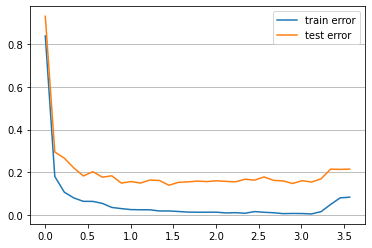

In [ ]:
  plt.plot(x_axis, y_train, label='train error')
  plt.plot(x_axis, y_test, label='test error')
  axes = plt.gca()
  axes.yaxis.grid()
  plt.legend() 

In [ ]:
## Place your code for your answer to question 1 in this box. 
interval = 50

list_N_values = np.arange(1,2000, interval)
x_axis = 2*list_N_values/len(Xt_train) # x-axis given by the number of parameters in the model (remember that's 2N) divided by the number of training data
y_train = []
y_test = []

for N1 in list_N_values:
   train_error, test_error = sgd_fit_1(Xt_train, yt_train, Xt_test, yt_test, N1, lr=0.001, epochs=300, batchsize=10)
   y_train.append(train_error) 
   y_test.append(test_error)

x_axis = x_axis.tolist()

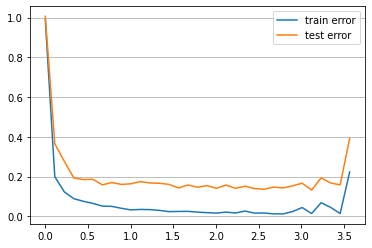

In [ ]:
  plt.plot(x_axis, y_train, label='train error')
  plt.plot(x_axis, y_test, label='test error')
  axes = plt.gca()
  axes.yaxis.grid()
  plt.legend() 

#### Answer 4 text

*Justify your choice of learning rate and model dimensionality. Compare this plot with the direct fit you did in numpy above. How do they differ?*

I chose an interval of 50 in order to avoid a long running time. The learning rate of 0.001 performed well in all experimentd from question 3 and it goes best with a small batch size fo 5 or 10. I chose epoch = 300 as it produced good results before and it's the value at which most 500 epoch runs were not yet starting to overtrain and have an incresing train error. 

As no experiments were done for values N > 1000, my choice of the hyperparameteres seems to not agree with values for N>1500, as we can see that after $3$ on the $x$ axis of both plots the error increases. This is probably similar to what happend when the learning rate was too high at N>400 and the model exploded. When N>1500, a smaller learing rate would be needed for more granular training.

In comparison with the graph from Q1, this one does not blow up around the value $1$ on the $x$ axis. In the plot from Q1 we used the fixed point update equation, while here we use SGD which is more stable. 



## Sawtooth network

This part of the assignment looks at the *sawtooth* network Ferenc showed in the third lecture to demonstrate that deep ReLU networks can represent exponentially complex piecewise linear functions. The function is defined by the following recursion:

\begin{align}
f_l(x) &= 2\cdot \vert f_{l-1}(x)\vert - 2\\
f_0(x) &= x
\end{align}

This function can be implemented as a deep, narrow neural network with just two ReLU units at each layer. Below, I provide a simple `pytorch` implementation. The network has three different layers in it: the input layer, the middle layers, which are repeated, and the output layer. ReLU nonlinearities are sandwiched between them.


In [ ]:
from torch.nn import Identity, Sequential, Linear, ReLU

def sawtooth_input_layer():
  '''Input layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(1, 2, bias=False)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[1], [-1]])
  return layer 

def sawtooth_middle_layer():
  '''Middle layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
    layer.bias.data = torch.Tensor([-2, 2])
  return layer

def sawtooth_output_layer():
  '''Output layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(2, 1)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2]])
    layer.bias.data = torch.Tensor([-2])

  return layer

def get_sawtooth_network(num_hidden_layers = 5, middle_layer = sawtooth_middle_layer):
  '''Returns a nn.Sequential model with ReLU activations and weights fixed to
  implement the sawtooth function.
  
  Parameters
  ----------
  num_hidden_layers : int
    Specifies the number of hidden layers. When 0, the Identity is returned.
  middle_layer: function
    Function to use to construct the layers in the middle. Default is to use
    `sawtooth_middle_layer`.
  '''
  blocks = []
  if num_hidden_layers < 0:
    raise ValueError('Number of hidden layers must be non-negative')  
  elif num_hidden_layers == 0:
    blocks = [Identity]
  else:
    for l in range(num_hidden_layers):
      if l==0:
        blocks.append(sawtooth_input_layer())
      else:
        blocks.append(middle_layer())
      blocks.append(ReLU())
    blocks.append(sawtooth_output_layer())
  return Sequential(*blocks)
    

In pytorch, you can use models the same way as if they were python functions. Below I plot a 6-layer network's output. (note that we have to call `.detach` on the output of the model which detaches the data from the computational graph that was built, which would be used for automatic differentiation).

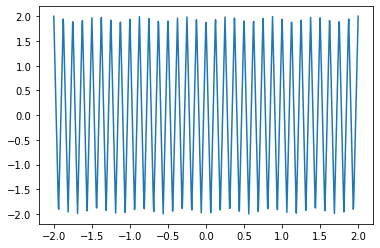

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.linspace(-2,2,1000)[:, None]

model = get_sawtooth_network(6)

plt.plot(x, model(x).detach());

The sawtooth network was deliberately constructed to show that exponentially complex networks can be represented by even very simple deep network architectures like this. But are they typical? How easy is it to break this exponential complexity property of the sawtooth networks? The assignment question below explores this a bit.

### Question 5

I implemented `get_sawtooth_network` so that it is possible to pass a custom functions for constructing the *middle* layers of the network. Create two new versions of this middle layer constructor in the code blocks below:

1. `noisy_sawtooth_middle_layer` should initialize the weights with a bit of random perturbation around the original fixed weights of the sawtooth network. The magnitude of the perturbation is controlled by an argument `noise_level`
2. `random_init_middle_layer` should initialize the weights completely randomly.

Create new models using these randomized layers and plot the model's output like above. I have included code blocks for plotting for convenience. Describe what you find. Is the number of linear segments still exponential?

Finally try reinitializing the whole model weights using standard initialization scheme. *Tip:* Use the `reset_parameters` function on each `Linear` layer in the model.

Please add a summmary to the text cell below.

*20 marks*

#### Q5: for both part 1 and 2

I have different interpretations for this question. 

If we just add noise with respect to the initial function:
\begin{align}
f_l(x) &= 2\cdot \vert f_{l-1}(x)\vert - 2\\
f_0(x) &= x
\end{align}

such that at each new invocation we get a different random (or just randomly noisy) pair (a,b):
\begin{align}
f_l(x) &= a\cdot \vert f_{l-1}(x)\vert - b\\
f_0(x) &= x
\end{align}

then the number of branches for a noisy sawtooth network with n hidden layers would still be $2^n$ as we double the branches each time we apply absolute value. 

However, I guess this is not exactly what the question was looking for, but it is a possible case nonetheless.

We can see an example below.


In [ ]:
# Case 1 - point on general case, noise or randomness
import random

def c1_noisy_sawtooth_middle_layer():
  '''A noisy middle layer of a Sawtooth network. A 2x2 linear layer whose weights
  are randomly perturbed around the fixed weights of the sawtooth network.

  Parameters
  ----------
  noise_level : float
    Controls the amount of noise added.
  '''
  w = random.uniform(1.5, 2.5)
  b = random.uniform(1.5, 2.5)
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[w, w], [(-1)*w, (-1)*w]])
    layer.bias.data = torch.Tensor([(-1)*b, b])
  return layer

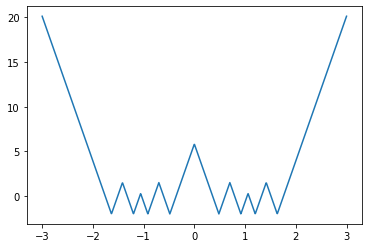

In [ ]:
x = torch.linspace(-3,3,1000)[:, None]

model = get_sawtooth_network(4, middle_layer = c1_noisy_sawtooth_middle_layer)

plt.plot(x, model(x).detach())

#### Q5 Part 1: random noise

*Create new models using these randomized layers and plot the model's output like above. I have included code blocks for plotting for convenience.*

My 1st assumption of random noise when the noise level is, for example, 0.1 is that each individual weight or bias will have randomly either added 0.1 to it, substracted 0.1 from it, or will have stayed the same.

Hence, for weight with initial value w and noise level noise_level, the randomly disturbed value of w will be:
w + np.random.choice([-1,0,1])*noise_level

After this I explore randomly distributed noise between (-0.1 and 0.1).

In [ ]:
# Modify the function below so it returns a layer with randomly perturbed
# weights and biases

def noisy_sawtooth_middle_layer(noise_level = 0.1):
  '''A noisy middle layer of a Sawtooth network. A 2x2 linear layer whose weights
  are randomly perturbed around the fixed weights of the sawtooth network.

  Parameters
  ----------
  noise_level : float
    Controls the amount of noise added.
  '''
  bool_arr = np.random.choice([-1,0,1], size=6) # might be perturbed positively, negatively or not at all
  layer = Linear(2, 2)
  # randomly perturbed weights noises and biases:
  w1 = 2 + bool_arr.item(0)*noise_level
  w2 = 2 + bool_arr.item(1)*noise_level
  w3 = bool_arr.item(2)*noise_level - 2
  w4 = bool_arr.item(3)*noise_level - 2
  b1 = bool_arr.item(4)*noise_level - 2
  b2 = 2 + bool_arr.item(5)*noise_level
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[w1, w2], [w3, w4]])
    layer.bias.data = torch.Tensor([b1, b2])
  return layer

In [ ]:
def get_noisy_sawtooth_network(num_hidden_layers = 5, middle_layer = noisy_sawtooth_middle_layer, noise_level = 0.1):
  '''Returns a nn.Sequential model with ReLU activations and weights fixed to
  implement the sawtooth function.
  
  Parameters
  ----------
  num_hidden_layers : int
    Specifies the number of hidden layers. When 0, the Identity is returned.
  middle_layer: function
    Function to use to construct the layers in the middle. Default is to use
    `sawtooth_middle_layer`.
  '''
  blocks = []
  if num_hidden_layers < 0:
    raise ValueError('Number of hidden layers must be non-negative')  
  elif num_hidden_layers == 0:
    blocks = [Identity]
  else:
    for l in range(num_hidden_layers):
      if l==0:
        blocks.append(sawtooth_input_layer())
      else:
        blocks.append(middle_layer(noise_level))
      blocks.append(ReLU())
    blocks.append(sawtooth_output_layer())
  return Sequential(*blocks)

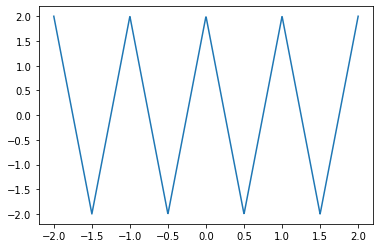

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.linspace(-2,2,1000)[:, None]

model = get_sawtooth_network(3)

plt.plot(x, model(x).detach())

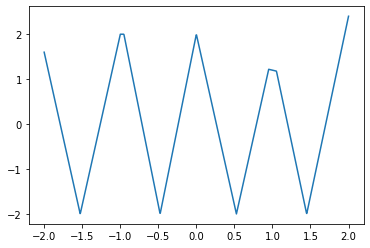

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

x = torch.linspace(-2,2,1000)[:, None]

model = get_noisy_sawtooth_network(3)

plt.plot(x, model(x).detach())

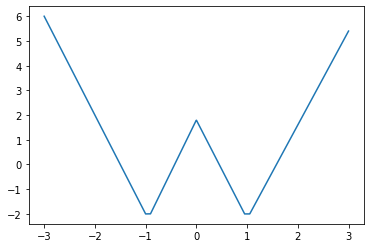

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

x = torch.linspace(-3,3,1000)[:, None]

model = get_noisy_sawtooth_network(2)

plt.plot(x, model(x).detach())

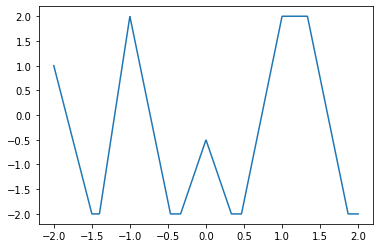

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

x = torch.linspace(-2,2,1000)[:, None]

model = get_noisy_sawtooth_network(3, noise_level = 0.5)

plt.plot(x, model(x).detach())

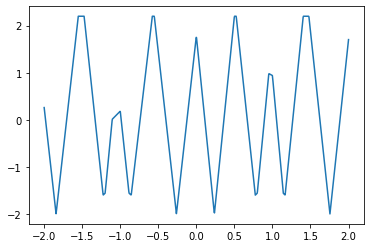

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

x = torch.linspace(-2,2,1000)[:, None]

model = get_noisy_sawtooth_network(4, noise_level= 0.1)

plt.plot(x, model(x).detach())

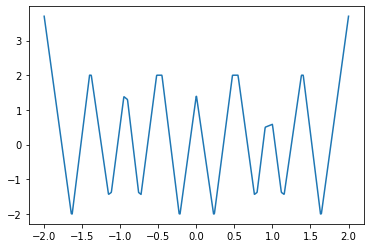

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]

model = get_noisy_sawtooth_network(4, noise_level= 0.1)

plt.plot(x, model(x).detach())

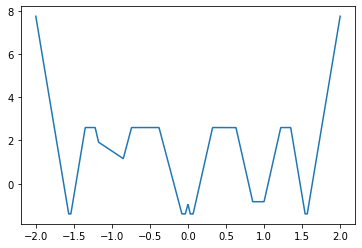

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]
model = get_noisy_sawtooth_network(4, noise_level= 0.3)
plt.plot(x, model(x).detach())

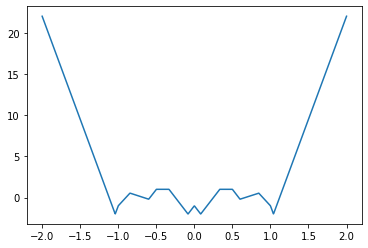

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]
model = get_noisy_sawtooth_network(4, noise_level= 0.5)
plt.plot(x, model(x).detach())

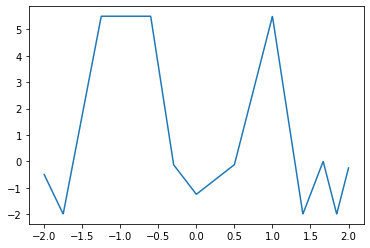

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]
model = get_noisy_sawtooth_network(4, noise_level= 0.5)
plt.plot(x, model(x).detach())

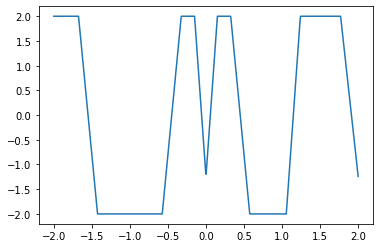

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]
model = get_noisy_sawtooth_network(4, noise_level= 0.7)
plt.plot(x, model(x).detach())

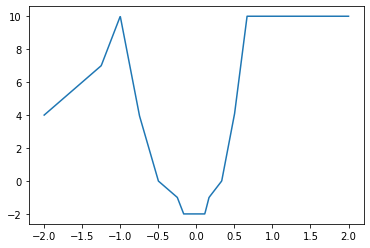

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]
model = get_noisy_sawtooth_network(4, noise_level= 1)
plt.plot(x, model(x).detach())

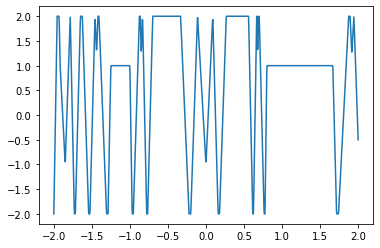

In [ ]:
x = torch.linspace(-2,2,1000)[:, None]
model = get_noisy_sawtooth_network(6, noise_level= 0.5)
plt.plot(x, model(x).detach())

#### Q5: Part 1

*Describe what you find. Is the number of linear segments still exponential?*

In non-noisy instances, the graph expression for a layer $l$ is:

\begin{align}
f_l(x) &= 2\cdot Relu(f_{l-1}(x)) +  2\cdot Relu(-f_{l-1}(x)) - 2\\
f_0(x) &= x
\end{align}

However, when we randomly add noise to the weights, the two $Relu$ invocations won't take a function and its respective negative anymore, as different noise will be added to both, so it'll be something closer to:

\begin{align}
f_l(x) &= 2\cdot Relu(f'_{l-1}(x)) +  2\cdot Relu(-f''_{l-1}(x)) - 2\\
f_0(x) &= x
\end{align}

Hence, when it comes to writing out the branches of the function, they won't necessarily mutually exclude or make up the entire interval (such as when writing \begin{align}\vert x - 5\vert =\begin{cases}
      x - 5 & \text{if $x>=5$}\\
      5 - x & \text{if $x < 5$}\\
    \end{cases}   
  \end{align} 

-- here the 2 cases are mutually exclusive, but also united make up all the reals). In our case, because of the new non-identical form (but with small noise, still somewhat close) of the functions, our branches might overlap, in which case, they add up and produce extra segments (for the interval on which they overlap). An example can be the horizontal lines in that we can see above. My guess is that these are formed when the slopes of $f'$ and $f''$ remain identical and we only add up the biases and hence get we get a constant function, which is a horizontal line. When the noise is small, we can visually distinguish these small extra segments from the rest. Not all are horizontal, when added up, the two lines will just produce another oblique line. 

When extra lines are produced, we can get more than $2^n$ total segments.

At the same time, iterating on this noisy function multiple times with new random noise for every new iteration, more branches will overlap, sometimes even merging. In this case, we will get less linear segments than $2^n$. 

Overall, it depends on how the two phenomenons propagate, but in general, it looks like they mostly cancel out, leaving around $2^n$ branches.



#### Q5: Part 1 
Second interpretation of noise_level: noise_level 0.1 means noise between -0.1 and 0.1
Here I choose a uniform distribution for noise. I also try a normal one after this.

In [ ]:
# Modify the function below so it returns a layer with randomly perturbed
# weights and biases

def noisy_sawtooth_middle_layer_1(noise_level = 0.1):
  '''A noisy middle layer of a Sawtooth network. A 2x2 linear layer whose weights
  are randomly perturbed around the fixed weights of the sawtooth network.

  Parameters
  ----------
  noise_level : float
    Controls the amount of noise added.
  '''
  noise_arr = []
  for i in range(6):
    noise_arr.append(random.uniform((-1)*noise_level, noise_level)) # choosing a uniform distribution for noise
  layer = Linear(2, 2)
  # randomly perturbed weights noises and biases:
  w1 = 2 + noise_arr[0]
  w2 = 2 + noise_arr[1]
  w3 = noise_arr[2] - 2
  w4 = noise_arr[3] - 2
  b1 = noise_arr[4] - 2
  b2 = 2 + noise_arr[5]
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[w1, w2], [w3, w4]])
    layer.bias.data = torch.Tensor([b1, b2])
  return layer

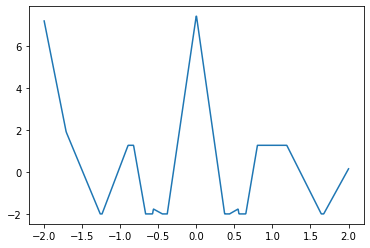

In [ ]:
from functools import partial

model = get_sawtooth_network(
    num_hidden_layers = 4,
    middle_layer = partial(noisy_sawtooth_middle_layer_1, noise_level=0.7)
  )
plt.plot(x, model(x).detach())

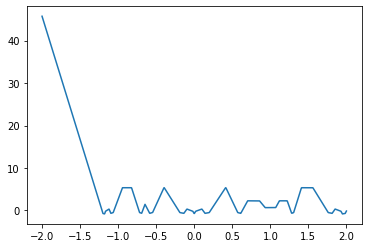

In [ ]:
model = get_sawtooth_network(
    num_hidden_layers = 5,
    middle_layer = partial(noisy_sawtooth_middle_layer_1, noise_level=0.7)
  )
plt.plot(x, model(x).detach())

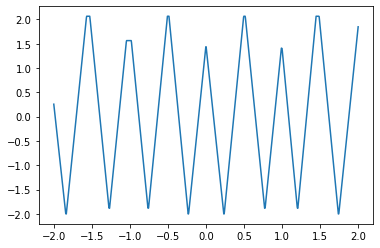

In [ ]:
model = get_sawtooth_network(
    num_hidden_layers = 4,
    middle_layer = partial(noisy_sawtooth_middle_layer_1, noise_level=0.1)
  )
plt.plot(x, model(x).detach())

#### Q5: Part 1 

The results are similar to the ones before, still around $2^n$ segments. The explanation is the same. However, when interpreting noise_level as an interval, if it has a small value, such as 0.1, then the noise will be evem smaller, as we can see in the last plot. But for higher values for noise_level, the plots look similar to when we don't use noise_level as an interval.

#### Q5 Part 1: normally distributed noise (this was an assumption made in the MLBI course)

In [ ]:
# Modify the function below so it returns a layer with randomly perturbed
# weights and biases

def noisy_sawtooth_middle_layer_2(noise_level = 0.1):
  '''A noisy middle layer of a Sawtooth network. A 2x2 linear layer whose weights
  are randomly perturbed around the fixed weights of the sawtooth network.

  Parameters
  ----------
  noise_level : float
    Controls the amount of noise added.
  '''
  noise_arr = []

  noise_arr = np.random.normal((-1)*noise_level, noise_level, 6) # choosing a normal distribution for noise
  noise_arr = noise_arr.tolist()

  layer = Linear(2, 2)

  # randomly perturbed weights noises and biases:
  w1 = 2 + noise_arr[0]
  w2 = 2 + noise_arr[1]
  w3 = noise_arr[2] - 2
  w4 = noise_arr[3] - 2
  b1 = noise_arr[4] - 2
  b2 = 2 + noise_arr[5]
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[w1, w2], [w3, w4]])
    layer.bias.data = torch.Tensor([b1, b2])
  return layer

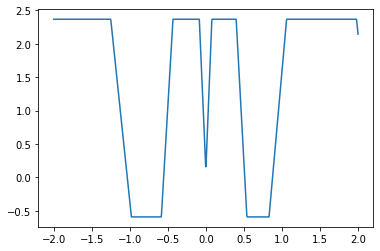

In [ ]:
model = get_sawtooth_network(
    num_hidden_layers = 4,
    middle_layer = partial(noisy_sawtooth_middle_layer_2, noise_level=0.5)
  )
plt.plot(x, model(x).detach())

#### Q5 Part 1 normal noise:

The noise is here is normal which means it's more often closer to the mean which is 0, giving similar slopes to Relus of opposite sign that add up and produce horizontal segments. Same explanation as before, around $2^n$ segments.

#### Q5 Part 2: random weights

*Finally try reinitializing the whole model weights using standard initialization scheme. **Tip:** Use the `reset_parameters` function on each `Linear` layer in the model.*

In [ ]:
# ORIGINAL
# Modify the function below so it returns a layer with randomly initialized
# weights and biases. 

def random_init_middle_layer(noise_level = 0.1):
  '''A randomly initialized 2x2 linear layer.'''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
    layer.bias.data = torch.Tensor([-2, 2])
  return layer

In [ ]:
# Modify the function below so it returns a layer with randomly initialized
# weights and biases. 

def random_init_middle_layer(noise_level = 0.1):
  '''A randomly initialized 2x2 linear layer.'''
  layer = Linear(2, 2)
  with torch.no_grad():
     layer.reset_parameters()
  return layer

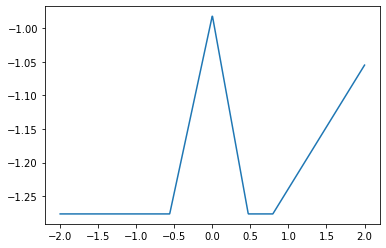

In [ ]:
model = get_sawtooth_network(
    num_hidden_layers = 3,
    middle_layer = partial(random_init_middle_layer, noise_level=0.1)
  )
plt.plot(x, model(x).detach())

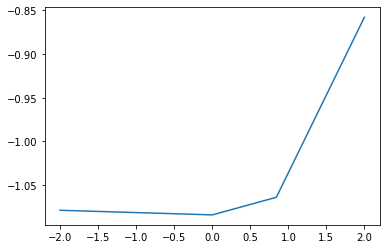

In [ ]:
model = get_sawtooth_network(
    num_hidden_layers = 4,
    middle_layer = partial(random_init_middle_layer, noise_level=0.1)
  )
plt.plot(x, model(x).detach())

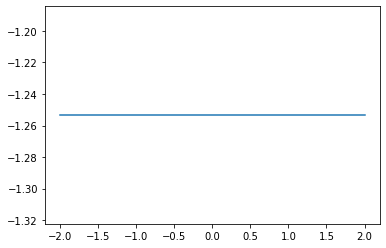

In [ ]:
model = get_sawtooth_network(
    num_hidden_layers = 5,
    middle_layer = partial(random_init_middle_layer, noise_level=0.1)
  )
plt.plot(x, model(x).detach())

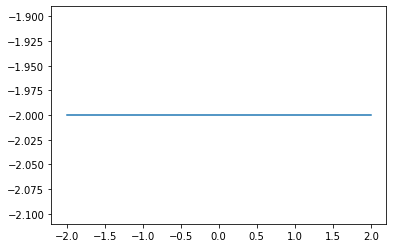

In [ ]:
model = get_sawtooth_network(
    num_hidden_layers = 6,
    middle_layer = partial(random_init_middle_layer, noise_level=0.1)
  )
plt.plot(x, model(x).detach())

#### Q5 Part 2

Previously, we still had some control over the number of segments, as the biases, even with noise, kept their signs and ensured branching. But here, we have no control over that. Half the time we will get \begin{align}\vert \vert f(x)\vert + positive\_bias \vert = \vert f(x)\vert + positive\_bias 
  \end{align}  which gives no additional branching. 
  Hence we will have quite a small number of different segments.
  Additionally, $reset\_parameters$ gives weights and biases between $-1$ and $1$ (not sure of the distribution). Hence, when we multiply slopes over and over again (as many times as the number of hidden layers), we will get final slopes that are insignificantly small, rendering $x$ useless. Whatever the intercepts add up to will give a constant horizontal function. 
This happens with higher and higher probability as we increase the number of hidden layers, as the slopes will get smaller and smaller.

This can be seen in the plots above. 

Most of the time, the networks with a high number of hidden layers give a horizontal line. In most cases, even with a small number of hidden layer, the plot will only have a small number of linear segments. Hence, this is not exponential anymore. 

## Data Movement

During the hardware lecture last Thursday, Nic discussed the importance of data movement and overhead (such as increased latency) that can occur when data is forced to 'spill over' into slow parts of the memory/storage hierarchy during inference or training. 

To assist with this challenge a range of model architectures have been developed that have small memory footprints. One very popular architecture of this variety is  [MobileNetv2](https://arxiv.org/abs/1801.04381). It was designed to run on smartphones and similar devices through an architecture that reduces memory and compute requirements, while still maintaining accuracy for common vision tasks.





### Question 6

__Part 1:__ The working set of each layer in the model (defined during the Thursday lecture) is one way of defining the memory requirement of a neural network. Estimate the working set of each layer of MobileNetv2 and provide it as a table assuming only inference is performed. In the MobileNetv2 paper linked above, you will find Table 2 provides a detailed description of each layer of the model, please base your answer on this specification. You can compute this by hand, or you could specify the architecture in pytorch and use a function like [modelsummary](https://pypi.org/project/pytorch-model-summary/) to help you. Include a brief explaination as to how you calculated the values for your table. *Please remember the working set memory of each layer will be larger than just the weight parameters alone.*

__Part 2:__ Assume that you perform inference using MobileNetv2 on a low-end mobile processor that has 128Kb of on-chip memory available for the model to use. Your input is 56x56 in size, how many times when performing one inference will you need to use off-chip memory?  

*If you find it necessary to make certain assumptions when providing your answers, please briefly state them as part of your answer.*

*20 marks*

#### Answer 6 Part 1

Below I use Pytorch's implementation of MobileNetv2. 

Resource: https://pytorch.org/hub/pytorch_vision_mobilenet_v2/



In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in C:\Users\Francesca/.cache\torch\hub\pytorch_vision_v0.6.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([ 2.0977e+00, -1.7348e+00, -2.2355e+00, -2.9669e+00, -2.3805e+00,
         9.7397e-01, -1.6049e+00,  3.6914e+00,  6.3812e+00, -1.2929e+00,
        -6.7555e+00, -3.3525e+00, -7.9619e+00, -4.4554e+00, -5.6423e+00,
        -4.6624e+00, -1.9577e+00, -3.5811e-01, -1.2812e+00, -4.6707e+00,
        -3.2935e+00, -2.5674e+00, -2.4351e+00, -1.3017e+00, -3.2453e+00,
        -1.4237e+00, -1.2001e+00,  4.1275e-01, -1.6093e+00,  1.5871e+00,
         2.7725e-01, -6.2652e-01, -2.9734e-01, -3.8219e+00, -1.5450e+00,
        -2.8976e+00, -5.6528e-01, -2.3938e+00, -3.3705e-01,  1.2809e+00,
        -1.2516e+00, -2.6469e+00, -3.1011e+00, -2.2447e+00, -4.4385e-01,
        -1.2620e+00,  8.2896e-01, -2.0436e+00, -6.6036e-01, -8.6518e-02,
         4.8967e-01, -1.7190e+00, -7.7943e-01, -1.1046e+00, -5.3857e-01,
        -2.9254e+00, -1.9327e+00, -2.7273e+00, -6.0903e-01, -1.6802e+00,
         1.3443e+00, -4.2062e+00, -1.4768e+00, -4.5581e+00, -3.2726e+00,
        -4.0086e+00,  1.5702e-01, -1.9921e+00, -7.4

In [ ]:
%pip install pytorch-model-summary


You should consider upgrading via the 'c:\Users\Francesca\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [ ]:
from pytorch_model_summary import summary
# show input shape
print(summary(model, torch.zeros((1, 3, 224, 224)).cuda(), show_input=True))

-----------------------------------------------------------------------------
          Layer (type)           Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 3, 224, 224]             864             864
         BatchNorm2d-2     [1, 32, 112, 112]              64              64
               ReLU6-3     [1, 32, 112, 112]               0               0
    InvertedResidual-4     [1, 32, 112, 112]             896             896
    InvertedResidual-5     [1, 16, 112, 112]           5,136           5,136
    InvertedResidual-6       [1, 24, 56, 56]           8,832           8,832
    InvertedResidual-7       [1, 24, 56, 56]          10,000          10,000
    InvertedResidual-8       [1, 32, 28, 28]          14,848          14,848
    InvertedResidual-9       [1, 32, 28, 28]          14,848          14,848
   InvertedResidual-10       [1, 32, 28, 28]          21,056          21,056
   InvertedResidual-11       [1, 64, 14, 14]          54,272          54,27

In [ ]:
from pytorch_model_summary import summary
# show input shape
print(summary(model, input_batch, show_input=True))

-----------------------------------------------------------------------------
          Layer (type)           Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 3, 224, 224]             864             864
         BatchNorm2d-2     [1, 32, 112, 112]              64              64
               ReLU6-3     [1, 32, 112, 112]               0               0
    InvertedResidual-4     [1, 32, 112, 112]             896             896
    InvertedResidual-5     [1, 16, 112, 112]           5,136           5,136
    InvertedResidual-6       [1, 24, 56, 56]           8,832           8,832
    InvertedResidual-7       [1, 24, 56, 56]          10,000          10,000
    InvertedResidual-8       [1, 32, 28, 28]          14,848          14,848
    InvertedResidual-9       [1, 32, 28, 28]          14,848          14,848
   InvertedResidual-10       [1, 32, 28, 28]          21,056          21,056
   InvertedResidual-11       [1, 64, 14, 14]          54,272          54,27

In [ ]:
# show output shape
print(summary(model, torch.zeros((1, 3, 224, 224)).cuda(), show_input=False))

-----------------------------------------------------------------------------
          Layer (type)          Output Shape         Param #     Tr. Param #
              Conv2d-1     [1, 32, 112, 112]             864             864
         BatchNorm2d-2     [1, 32, 112, 112]              64              64
               ReLU6-3     [1, 32, 112, 112]               0               0
    InvertedResidual-4     [1, 16, 112, 112]             896             896
    InvertedResidual-5       [1, 24, 56, 56]           5,136           5,136
    InvertedResidual-6       [1, 24, 56, 56]           8,832           8,832
    InvertedResidual-7       [1, 32, 28, 28]          10,000          10,000
    InvertedResidual-8       [1, 32, 28, 28]          14,848          14,848
    InvertedResidual-9       [1, 32, 28, 28]          14,848          14,848
   InvertedResidual-10       [1, 64, 14, 14]          21,056          21,056
   InvertedResidual-11       [1, 64, 14, 14]          54,272          54,27

#### Q6 Part 1 answers:

The assumptions I make are the following:

The size of each parameter is 16 bits = 2 bytes (as per the cited paper) I am also assuming that for each layer, we use 16 bits per individual channel of a "pixel". Eg: for a 3 channel $224*224$ image we have $3*224*224*16 bits$, instead of just $3*224*224*8$. 
The math for the working set of a layer is input_size + output_size + parameters_size.

$Input\_Size = Input\_batch\_size * Input\_channels * Input\_size 1 * Input\_size 2 * 2/1024  (kB)$

same for output size

$Params\_size = Params * 2 / 1024 (kB)$

$Working\_set\_size = Inpute\_size + Output\_size + Params\_size$

|Layer(type)          | Input batch size | Input channels | Input size 1 | Input size 2 | Output batch size | Output channels | Output size 1  | Output size 2 |      Params     |  Tr. Params         |    Input Size     |   Output Size       |    Params size         |   Working set size (kB)         | Working set size (MB)             |
|---------------------|------------|----------|--------------|--------------|------------|---------|---------------|--------------|-----------|-----------|---------|----------|-------------|------------|--------------|
| Conv2d-1            | 1          | 3        | 224          | 224          | 1          | 32      | 112           | 112          | 864       | 864       | 294     | 784      | 1.6875      | 1079.6875  | 1.054382324  |
| BatchNorm2d-2       | 1          | 32       | 112          | 112          | 1          | 32      | 112           | 112          | 64        | 64        | 784     | 784      | 0.125       | 1568.125   | 1.53137207   |
| ReLU6-3             | 1          | 32       | 112          | 112          | 1          | 32      | 112           | 112          | 0         | 0         | 784     | 784      | 0           | 1568       | 1.53125      |
| InvertedResidual-4  | 1          | 32       | 112          | 112          | 1          | 16      | 112           | 112          | 896       | 896       | 784     | 392      | 1.75        | 1177.75    | 1.150146484  |
| InvertedResidual-5  | 1          | 16       | 112          | 112          | 1          | 24      | 56            | 56           | 5,136     | 5,136     | 392     | 147      | 10.03125    | 549.03125  | 0.5361633301 |
| InvertedResidual-6  | 1          | 24       | 56           | 56           | 1          | 24      | 56            | 56           | 8,832     | 8,832     | 147     | 147      | 17.25       | 311.25     | 0.3039550781 |
| InvertedResidual-7  | 1          | 24       | 56           | 56           | 1          | 32      | 28            | 28           | 10,000    | 10,000    | 147     | 49       | 19.53125    | 215.53125  | 0.2104797363 |
| InvertedResidual-8  | 1          | 32       | 28           | 28           | 1          | 32      | 28            | 28           | 14,848    | 14,848    | 49      | 49       | 29          | 127        | 0.1240234375 |
| InvertedResidual-9  | 1          | 32       | 28           | 28           | 1          | 32      | 28            | 28           | 14,848    | 14,848    | 49      | 49       | 29          | 127        | 0.1240234375 |
| InvertedResidual-10 | 1          | 32       | 28           | 28           | 1          | 64      | 14            | 14           | 21,056    | 21,056    | 49      | 24.5     | 41.125      | 114.625    | 0.1119384766 |
| InvertedResidual-11 | 1          | 64       | 14           | 14           | 1          | 64      | 14            | 14           | 54,272    | 54,272    | 24.5    | 24.5     | 106         | 155        | 0.1513671875 |
| InvertedResidual-12 | 1          | 64       | 14           | 14           | 1          | 64      | 14            | 14           | 54,272    | 54,272    | 24.5    | 24.5     | 106         | 155        | 0.1513671875 |
| InvertedResidual-13 | 1          | 64       | 14           | 14           | 1          | 64      | 14            | 14           | 54,272    | 54,272    | 24.5    | 24.5     | 106         | 155        | 0.1513671875 |
| InvertedResidual-14 | 1          | 64       | 14           | 14           | 1          | 96      | 14            | 14           | 66,624    | 66,624    | 24.5    | 36.75    | 130.125     | 191.375    | 0.1868896484 |
| InvertedResidual-15 | 1          | 96       | 14           | 14           | 1          | 96      | 14            | 14           | 118,272   | 118,272   | 36.75   | 36.75    | 231         | 304.5      | 0.2973632813 |
| InvertedResidual-16 | 1          | 96       | 14           | 14           | 1          | 96      | 14            | 14           | 118,272   | 118,272   | 36.75   | 36.75    | 231         | 304.5      | 0.2973632813 |
| InvertedResidual-17 | 1          | 96       | 14           | 14           | 1          | 160     | 7             | 7            | 155,264   | 155,264   | 36.75   | 15.3125  | 303.25      | 355.3125   | 0.3469848633 |
| InvertedResidual-18 | 1          | 160      | 7            | 7            | 1          | 160     | 7             | 7            | 320,000   | 320,000   | 15.3125 | 15.3125  | 625         | 655.625    | 0.6402587891 |
| InvertedResidual-19 | 1          | 160      | 7            | 7            | 1          | 160     | 7             | 7            | 320,000   | 320,000   | 15.3125 | 15.3125  | 625         | 655.625    | 0.6402587891 |
| InvertedResidual-20 | 1          | 160      | 7            | 7            | 1          | 320     | 7             | 7            | 473,920   | 473,920   | 15.3125 | 30.625   | 925.625     | 971.5625   | 0.9487915039 |
| Conv2d-21           | 1          | 320      | 7            | 7            | 1          | 1280    | 7             | 7            | 409,600   | 409,600   | 30.625  | 122.5    | 800         | 953.125    | 0.9307861328 |
| BatchNorm2d-22      | 1          | 1280     | 7            | 7            | 1          | 1280    | 7             | 7            | 2,560     | 2,560     | 122.5   | 122.5    | 5           | 250        | 0.244140625  |
| ReLU6-23            | 1          | 1280     | 7            | 7            | 1          | 1280    | 7             | 7            | 0         | 0         | 122.5   | 122.5    | 0           | 245        | 0.2392578125 |
| Dropout-24          | 1          | 1280     | 1            | 1            | 1          | 1280    | 1             | 1            | 0         | 0         | 2.5     | 2.5      | 0           | 5          | 0.0048828125 |
| Linear-25           | 1          | 1280     | 1            | 1            | 1          | 1000    | 1             | 1            | 1,281,000 | 1,281,000 | 2.5     | 1.953125 | 2501.953125 | 2506.40625 | 2.447662354  |

#### Answer 6 Part 2


In [ ]:
print(summary(model, torch.zeros((1, 3, 56, 56)).cuda(), show_input=True))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 3, 56, 56]             864             864
         BatchNorm2d-2     [1, 32, 28, 28]              64              64
               ReLU6-3     [1, 32, 28, 28]               0               0
    InvertedResidual-4     [1, 32, 28, 28]             896             896
    InvertedResidual-5     [1, 16, 28, 28]           5,136           5,136
    InvertedResidual-6     [1, 24, 14, 14]           8,832           8,832
    InvertedResidual-7     [1, 24, 14, 14]          10,000          10,000
    InvertedResidual-8       [1, 32, 7, 7]          14,848          14,848
    InvertedResidual-9       [1, 32, 7, 7]          14,848          14,848
   InvertedResidual-10       [1, 32, 7, 7]          21,056          21,056
   InvertedResidual-11       [1, 64, 4, 4]          54,272          54,272
   InvertedResidual-12  

In [ ]:
print(summary(model, torch.zeros((1, 3, 56, 56)).cuda(), show_input=False))

---------------------------------------------------------------------------
          Layer (type)        Output Shape         Param #     Tr. Param #
              Conv2d-1     [1, 32, 28, 28]             864             864
         BatchNorm2d-2     [1, 32, 28, 28]              64              64
               ReLU6-3     [1, 32, 28, 28]               0               0
    InvertedResidual-4     [1, 16, 28, 28]             896             896
    InvertedResidual-5     [1, 24, 14, 14]           5,136           5,136
    InvertedResidual-6     [1, 24, 14, 14]           8,832           8,832
    InvertedResidual-7       [1, 32, 7, 7]          10,000          10,000
    InvertedResidual-8       [1, 32, 7, 7]          14,848          14,848
    InvertedResidual-9       [1, 32, 7, 7]          14,848          14,848
   InvertedResidual-10       [1, 64, 4, 4]          21,056          21,056
   InvertedResidual-11       [1, 64, 4, 4]          54,272          54,272
   InvertedResidual-12  

Here I make the assumption that we need to access the off-chip memory at each layer $(layer\_working\_set - 128)/128$ times. So if we have 128*3 + 128 kB at a layer, we need to go back to off-chip memory 3 times.

| Layer (type)        | Input Shape     | Param #   | Output Shape     | Input+Otput+Params Memory(kB) | Off_chip memory accessed# |
|---------------------|-----------------|-----------|------------------|-------------------------------|---------------------------|
|                     |                 |           |                  |                               |                           |
| Conv2d-1            | [1, 3, 56, 56]  | 864       | [1, 32, 28, 28]  | 69.0625                       | 0                         |
| BatchNorm2d-2       | [1, 32, 28, 28] | 64        | [1, 32, 28, 28]  | 98.125                        | 0                         |
| ReLU6-3             | [1, 32, 28, 28] | 0         | [1, 32, 28, 28]  | 98                            | 0                         |
| InvertedResidual-4  | [1, 32, 28, 28] | 896       | [1, 16, 28, 28]  | 75.25                         | 0                         |
| InvertedResidual-5  | [1, 16, 28, 28] | 5,136     | [1, 24, 14, 14]  | 43.71875                      | 0                         |
| InvertedResidual-6  | [1, 24, 14, 14] | 8,832     | [1, 24, 14, 14]  | 35.625                        | 0                         |
| InvertedResidual-7  | [1, 24, 14, 14] | 10,000    | [1, 32, 7, 7]    | 31.78125                      | 0                         |
| InvertedResidual-8  | [1, 32, 7, 7]   | 14,848    | [1, 32, 7, 7]    | 35.125                        | 0                         |
| InvertedResidual-9  | [1, 32, 7, 7]   | 14,848    | [1, 32, 7, 7]    | 35.125                        | 0                         |
| InvertedResidual-10 | [1, 32, 7, 7]   | 21,056    | [1, 64, 4, 4]    | 46.1875                       | 0                         |
| InvertedResidual-11 | [1, 64, 4, 4]   | 54,272    | [1, 64, 4, 4]    | 110                           | 0                         |
| InvertedResidual-12 | [1, 64, 4, 4]   | 54,272    | [1, 64, 4, 4]    | 110                           | 0                         |
| InvertedResidual-13 | [1, 64, 4, 4]   | 54,272    | [1, 64, 4, 4]    | 110                           | 0                         |
| InvertedResidual-14 | [1, 64, 4, 4]   | 66,624    | [1, 96, 4, 4]    | 135.125                       | 1                         |
| InvertedResidual-15 | [1, 96, 4, 4]   | 118,272   | [1, 96, 4, 4]    | 237                           | 1                         |
| InvertedResidual-16 | [1, 96, 4, 4]   | 118,272   | [1, 96, 4, 4]    | 237                           | 1                         |
| InvertedResidual-17 | [1, 96, 4, 4]   | 155,264   | [1, 160, 2, 2]   | 307.5                         | 2                         |
| InvertedResidual-18 | [1, 160, 2, 2]  | 320,000   | [1, 160, 2, 2]   | 627.5                         | 4                         |
| InvertedResidual-19 | [1, 160, 2, 2]  | 320,000   | [1, 160, 2, 2]   | 627.5                         | 4                         |
| InvertedResidual-20 | [1, 160, 2, 2]  | 473,920   | [1, 320, 2, 2]   | 929.375                       | 7                         |
| Conv2d-21           | [1, 320, 2, 2]  | 409,600   | [1, 1280, 2, 2]  | 812.5                         | 6                         |
| BatchNorm2d-22      | [1, 1280, 2, 2] | 2,560     | [1, 1280, 2, 2]  | 25                            | 0                         |
| ReLU6-23            | [1, 1280, 2, 2] | 0         | [1, 1280, 2,  2] | 20                            | 0                         |
| Dropout-24          | [1, 1280]       | 0         | [1, 1280]        | 5                             | 0                         |
| Linear-25           | [1, 1280]       | 1,281,000 | [1, 1000]        | 2506.40625                    | 19                        |

The sum is $19+6+7+4+4+2+1+1+1 = 45$

Hence we have to access the off-chip memory 45 times for the inference of one image of size 56*56, given the assumptions made.